In [1]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Final Project Maestria\Markowitz")

In [3]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Final Project Maestria\Markowitz")
import numpy as np 
import pandas as pd 
from numbersAddTo1 import random_gen_weights
from unitCircle import unitCircle as unitCircleDf
import matplotlib.pyplot as plt
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns
np.random.seed(1986)

n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)       
    data.append(row)
data.append([1/30]*30)

#downloading only last year as I believe is more representative of the picture going forward
df_weights = pd.DataFrame(data)
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


#%%
## 41 rows of daily pct change in aug and sept 2024
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()

training_pct_change=training_1y_endJul2024.pct_change().dropna()

The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Final Project Maestria\Markowitz


[*********************100%***********************]  30 of 30 completed


In [4]:
port_means= []
port_sd = []
for row in df_weights.values: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
    port_sd.append(i_sd * np.sqrt(41))
    
#%%
#renaming columns and adding sharpe ratio
df_weights.columns = training_pct_change.columns
df_weights['port_return'] = port_means
df_weights['port_risk'] = port_sd
df_weights['sharpe'] = df_weights['port_return']/df_weights['port_risk']

**Notice that we are using Constraint and Bounds**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

<iframe width='800px' height='800px' src='https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize'></iframe>

- sum == 1 
    -  this parameter is only used if we use SLSQP (Sequential Least Squares Programming)
- From Scipy documentation: <br>
    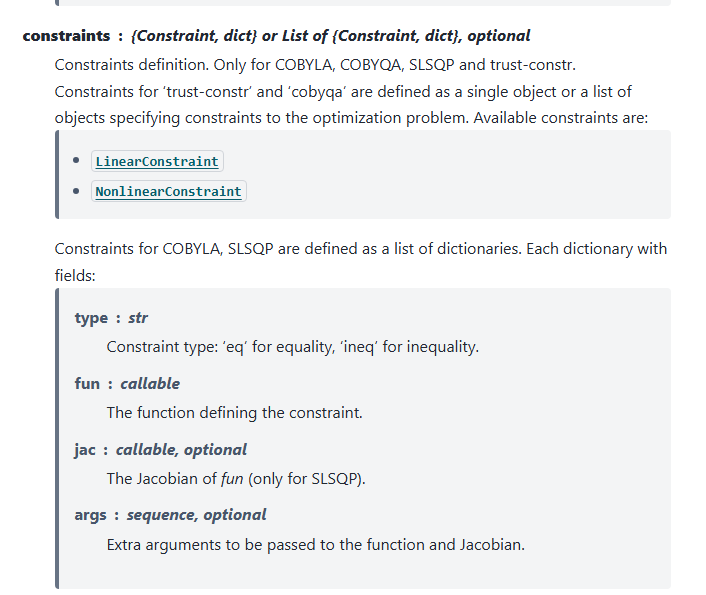 <br>
- Parameters: [0,1] <br>
    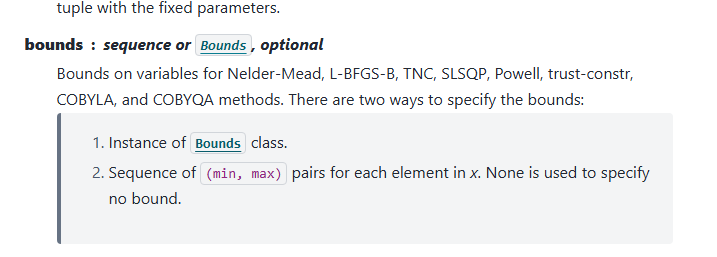

In [5]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]


## Result from Minimize

In [6]:
df_weights.loc[:,"AAPL":"WMT"].apply(lambda x: all( round(x,2) )== round(1/30,2),axis=1).sum()

0

In [7]:

# Set display option for pandas
pd.set_option('display.max_columns', 500)

In [8]:
metoFila = []
for _iterRow in df_weights.values: 
    first30 = _iterRow[:30]
    totalTrue = 0
    for value in first30:
        if value == 1/30:
            totalTrue+=1
    if totalTrue == 30: 
        metoFila.append(_iterRow)

In [9]:
len(metoFila)

1

In [10]:
df_weights[(df_weights.iloc[:, :30] == 1/30).all(axis=1)]

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT,port_return,port_risk,sharpe
10000,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.025254,0.038736,0.651952


In [11]:
#initial_guess = [1. / returns.shape[1]] * returns.shape[1]
initial_guess = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()
from scipy.optimize import minimize
result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimized Weights:", result.x)
print("Maximized Sharpe Ratio:", -result.fun)


Optimized Weights: [8.18727742e-16 1.07286094e-01 7.53233949e-02 9.05408580e-02
 1.32563707e-16 1.86183942e-16 1.77417418e-16 1.60489676e-16
 1.68407525e-16 8.44982837e-17 5.50623124e-17 2.61839902e-02
 2.10913435e-17 1.03098681e-16 9.70107630e-02 0.00000000e+00
 2.09129193e-16 1.22983104e-01 6.81927278e-17 9.33345972e-17
 3.60905249e-02 2.47723927e-16 5.43364542e-02 8.14857085e-16
 5.64179331e-17 3.28324294e-02 4.01208738e-02 6.46675967e-17
 1.12648639e-01 2.04642875e-01]
Maximized Sharpe Ratio: 1.2881771546336285


**iterating over portfolio weights to minimize**<br>

Following similar process as before


In [18]:
best100s=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0:100,:]

In [18]:
np.random.choice(best100s.shape[0])

69

In [19]:
# iterating over 100 best portfolios 
best_result = 0 
best_weights = 0

for i,x in enumerate(best100s.values):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = x    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        best_result = -result.fun 
        best_weights = result.x

        print("Best Sharpe Ratio So Far:", -result.fun)

Best Sharpe Ratio So Far: 1.2881771546336285
Best Sharpe Ratio So Far: 1.2881772131660678
Best Sharpe Ratio So Far: 1.288177225082723


In [21]:

portfolio_return(best_weights,training_pct_change)

0.05291379185645433

In [27]:
portfolio_risk(best_weights,training_pct_change)/portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)

1.060412200641832

In [22]:
portfolio_return([1/30 for x in range(30)],training_pct_change)

0.025254228640388447

In [26]:
portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)

0.03873633715637284

In [23]:
5.29/2.52

2.0992063492063493

**iterating over 100 random portfolios** <br>

In [14]:
np.random.seed(123)
allPortfolios = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True)
random100Portfolios=np.random.choice(allPortfolios.shape[0],size=100,replace=False)

In [15]:
# iterating over 100 best portfolios 
best_result = 0 
best_weights = 0

for i,x in enumerate(random100Portfolios):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = allPortfolios.iloc[x,:]    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        best_result = -result.fun 
        best_weights = result.x

        print("Best Sharpe Ratio So Far:", -result.fun)

Best Sharpe Ratio So Far: 1.2881770731519724
Best Sharpe Ratio So Far: 1.288177209906549
Best Sharpe Ratio So Far: 1.2881772170383652


In [80]:
from copy import deepcopy
best1_weights= deepcopy( result.x)

In [81]:
init_guess=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:]

In [82]:
init_guess=np.array( init_guess)

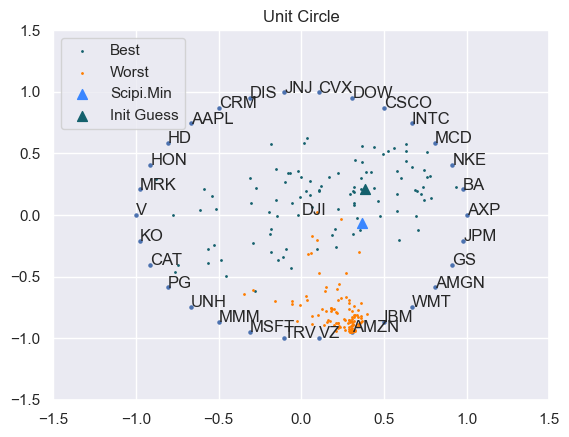

In [83]:

# PLOTTING UNICIRCLE

unitCircleDf['securities'] =\
df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:1000,:].\
        loc[:,"AAPL":"WMT"].\
            rank(axis=1, method='max',ascending=False).\
            apply(lambda x: np.count_nonzero(x<=5),axis=0).sort_values().index


#%%
nbr_portfolios = 100

best1000portfolios = df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

worst1000portfolios = df_weights.\
    sort_values('sharpe',ascending=True).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

bestPort_coord = pd.DataFrame(
    {
        'best_length': [np.array(x).dot(unitCircleDf.lengths) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values],
        'best_height': [np.array(x).dot(unitCircleDf.heights) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)

worstPort_coord = pd.DataFrame(
    {
        'worst_length': [np.array(x).dot(unitCircleDf.lengths) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values],
        'worst_height': [np.array(x).dot(unitCircleDf.heights) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)
#[value for value in best1_weights]
minimize_best1_coord =  pd.DataFrame(
    {
        'best_length': [best1_weights.dot(unitCircleDf.lengths)],
        'best_height': [best1_weights.dot(unitCircleDf.heights)]
    }
)

init_guess_coord =  pd.DataFrame(
    {
        'best_length': [init_guess.dot(unitCircleDf.lengths)],
        'best_height': [init_guess.dot(unitCircleDf.heights)]
    }
)

# plotting top n portfolios (blue), and bottom (1000) portfolios


plt.scatter(x=unitCircleDf.lengths, y=unitCircleDf.heights, s=5, color='b')
# Add labels
for i, txt in enumerate(unitCircleDf['securities']):
    plt.annotate(txt, (unitCircleDf['lengths'][i], unitCircleDf['heights'][i]))

plt.scatter(x=bestPort_coord.best_length, y=bestPort_coord.best_height, s=1, color='#15616d', label = 'Best')
plt.scatter(x=worstPort_coord.worst_length, y=worstPort_coord.worst_height, s=1, color='#ff7d00', label = 'Worst')
plt.scatter(x=minimize_best1_coord.best_length, y=minimize_best1_coord.best_height, s=50, color='#3a86ff', label = 'Scipi.Min',marker='^')
plt.scatter(x=init_guess_coord.best_length, y=init_guess_coord.best_height, s=50, color='#15616d', label = 'Init Guess',marker='^')
plt.annotate('DJI', (0, 0))
# Adding legend with bigger dots
plt.legend(markerscale=1)    



plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title('Unit Circle')
plt.show()


Note that sharpe ratio from the new optimized portfolio is 1.28 compared vs the best from random port weights of 1.07

In [86]:
df_weights.sort_values('sharpe',ascending=False).head(1)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WMT,port_return,port_risk,sharpe
14652,0.0,0.17,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.058013,0.053803,1.078258


In [87]:
[best1_weights]

[array([1.02975626e-15, 1.07286453e-01, 7.53232594e-02, 9.05409391e-02,
        1.37836712e-16, 8.45780466e-17, 0.00000000e+00, 3.64887294e-16,
        1.82917998e-17, 1.24263994e-16, 1.41394948e-16, 2.61840937e-02,
        1.11518165e-16, 4.91703949e-17, 9.70106532e-02, 5.17723123e-17,
        1.58099805e-16, 1.22982891e-01, 3.21909278e-16, 1.05053479e-16,
        3.60905626e-02, 1.13768388e-15, 5.43363401e-02, 3.06362052e-16,
        1.02005771e-16, 3.28325676e-02, 4.01206738e-02, 2.76842404e-16,
        1.12648446e-01, 2.04643120e-01])]

In [88]:
for row in [best1_weights]: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    mean2months=i_mean*41
    sd2_months=i_sd * np.sqrt(41)
    print(mean2months/sd2_months)

1.2881777139794794
